In [2]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import math
from dataclasses import dataclass

np.random.seed(seed=999) #baka

%matplotlib inline

### 1. Исходные данные

In [3]:
sample1_k = 2
sample1_size = 150
sample1 = stats.chi2(sample1_k).rvs(sample1_size)
sample1_m = np.mean(sample1)
sample1_s2 = np.var(sample1, ddof=1)
sample1_s = math.sqrt((sample1_size / (sample1_size - 1)) * sample1_s2) 

In [4]:
print(f"X: mean: {sample1_m:.3f} var: {sample1_s2:.3f} std: {np.std(sample1, ddof = 1):.3f}")

X: mean: 2.319 var: 4.991 std: 2.234


### 2. Визуальное представление выборки

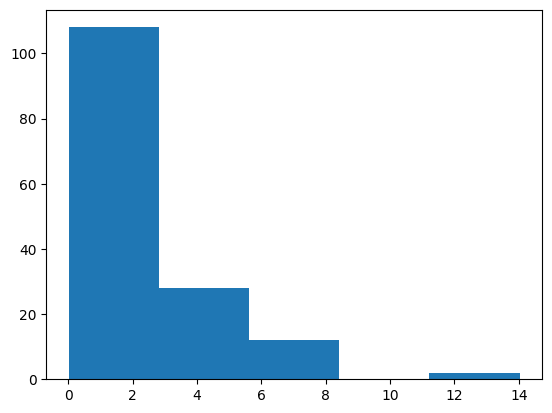

In [5]:
_ = plt.hist(sample1, bins=5)

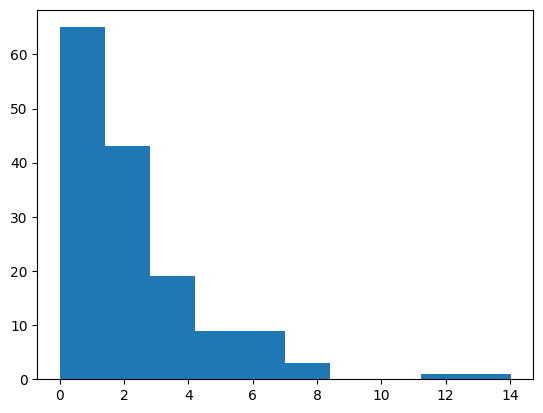

In [6]:
_ = plt.hist(sample1, bins=10)

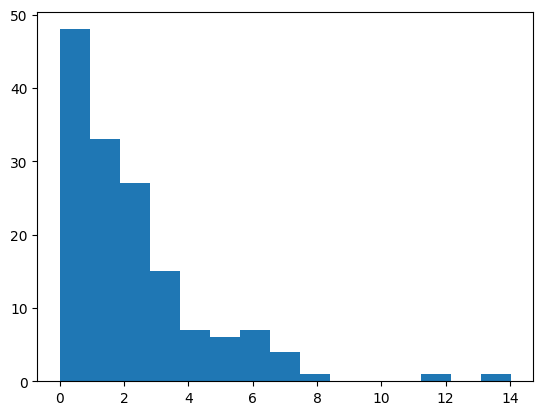

In [7]:
_ = plt.hist(sample1, bins=15)

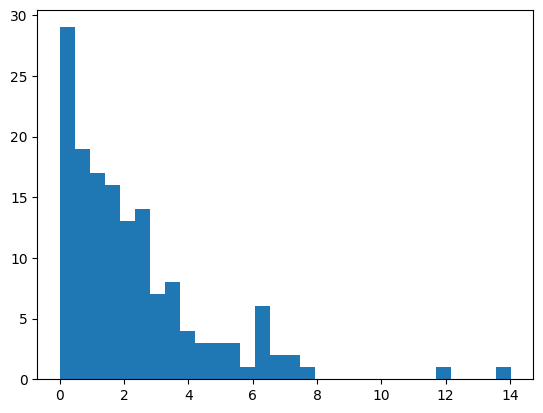

In [8]:
_ = plt.hist(sample1, bins=30)

### 3. Критерий хи-квадрат

In [9]:
def freqs_from_cdf(cdf, size, bin_num, begin, end):
    bin_size = abs(end - begin) / bin_num
    freqs = np.array([], dtype=float)
    for x in np.linspace(begin, end, bin_num, endpoint=False):
        freqs = np.append(freqs, (cdf(x + bin_size) - cdf(x)) * size)
    return freqs

def merge_by_indices(hist, bins_to_merge):
    bins_to_merge_new = np.copy(bins_to_merge)
    new_hist = np.copy(hist)
    
    for indices in bins_to_merge_new:
        new_hist = np.insert(new_hist, indices[0], new_hist[indices[0]:indices[1]].sum())
        new_hist = np.delete(new_hist, range(indices[0] + 1, indices[1] + 1))
        bins_to_merge_new -= (indices[1] - indices[0]) - 1 
        
    return new_hist
    
def merge_lower_than_threshold(hist, threshold, max_merges=3):
    bins_to_merge = np.empty((0, 2), dtype=int)
    count = 0
    for i in range(hist.size):
        if hist[i] < threshold:
            count += 1
        if hist[i] >= threshold and count != 0 or count > max_merges:
            bins_to_merge = np.vstack((bins_to_merge, [i - count, i]))
            count = 0
    
    if count != 0:
        bins_to_merge = np.vstack((bins_to_merge, [hist.size - count, hist.size]))

    
    return merge_by_indices(hist, bins_to_merge), bins_to_merge

@dataclass
class ChisquareResult:
    stat: float
    pvalue: float
    samp_hist: np.ndarray
    exp_hist: np.ndarray

def chisquare(sample, exp_cdf, bin_num, ddof=0, merge_threshold=3, max_merges=4, begin=None, end=None):
    if begin is None:
        begin = sample.min()
    
    if end is None:
        end = sample.max()
    
    sample = sample[(sample >= begin) & (sample <= end)]
    
    samp_hist, _ = np.histogram(sample, bins=bin_num)
    samp_hist, bins_to_merge = merge_lower_than_threshold(samp_hist, merge_threshold, max_merges)
    
    exp_hist = freqs_from_cdf(exp_cdf, sample.size, bin_num, begin, end)
    exp_hist = merge_by_indices(exp_hist, bins_to_merge)
    
    stat = 0
    for i in range(exp_hist.size):
        stat += (samp_hist[i] - exp_hist[i])**2 / exp_hist[i]
    pvalue = 1 - stats.chi2(exp_hist.size - ddof - 1).cdf(stat)
    
    return ChisquareResult(stat, pvalue, samp_hist, exp_hist)



#### а) Статистическая гипотеза: $H_0: X \sim N(m, σ)$

In [10]:
for bins in [5, 10, 15, 30]:
    res = chisquare(sample1, stats.norm(sample1_m, sample1_s).cdf, bins, ddof=2)
    print(f"bins: {bins} stat: {res.stat:.3f} pvalue: {res.pvalue}")

bins: 5 stat: 43.502 pvalue: 4.2342795936178845e-11
bins: 10 stat: 63.024 pvalue: 6.705747068735946e-13
bins: 15 stat: 1463.875 pvalue: 0.0
bins: 30 stat: 37235.910 pvalue: 0.0


#### б) Статистическая гипотеза: $H_0: X \sim R(a, b)$

a: -1.5633523336031896, b: 6.201900481249343


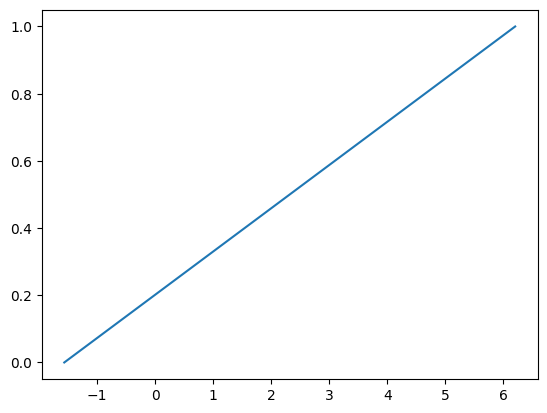

In [11]:
a = 1/2 * (2*sample1_m - sample1_s * (12)**(1/2))
b = 1/2 * (2*sample1_m + sample1_s * (12)**(1/2))
print(f"a: {a}, b: {b}")

x = np.linspace(a, b, 10000)
plt.plot(x, stats.uniform(a, b - a).cdf(x))

In [12]:
for bins in [5, 10, 15, 30]:
    res = chisquare(sample1, stats.uniform(a, b - a).cdf, bins, begin=a, end=b, ddof=2)
    print(f"bins: {bins} stat: {res.stat:.3f} pvalue: {res.pvalue}")

bins: 5 stat: 64.972 pvalue: 7.771561172376096e-15
bins: 10 stat: 66.873 pvalue: 6.314393452555578e-12
bins: 15 stat: 74.338 pvalue: 4.900169159327561e-11
bins: 30 stat: 83.951 pvalue: 7.1950608804272065e-09


#### в) Статистическая гипотеза: $H_0 \sim \chi^2(5)$

bins: 5 stat: 153.830 pvalue: 0.0
bins: 10 stat: 298.649 pvalue: 0.0
bins: 15 stat: 443.106 pvalue: 0.0
bins: 30 stat: 877.176 pvalue: 0.0


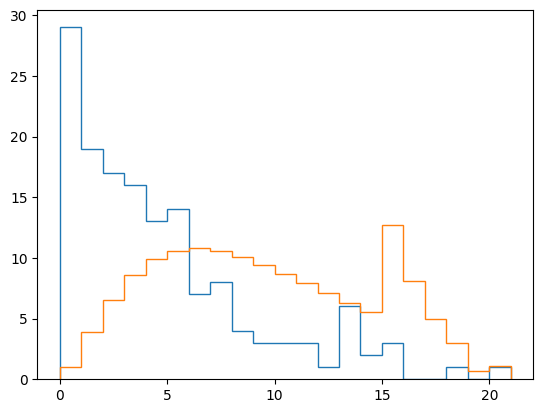

In [13]:
for bins in [5, 10, 15, 30]:
    res = chisquare(sample1, stats.chi2(5).cdf, bins, merge_threshold=2, max_merges=2)
    print(f"bins: {bins} stat: {res.stat:.3f} pvalue: {res.pvalue}")

plt.stairs(res.samp_hist)
_ = plt.stairs(res.exp_hist)

#### 4. Критерий Колмогорова

In [14]:
res = stats.kstest(sample1, stats.norm(sample1_m, sample1_s).cdf)
print(f"norm(m, sigma): stat: {res.statistic:.3f} pvalue: {res.pvalue}")

res = stats.kstest(sample1, stats.uniform(a, b - a).cdf)
print(f"uniform: stat: {res.statistic:.3f} pvalue: {res.pvalue}")

res = stats.kstest(sample1, stats.chi2(5).cdf)
print(f"uniform: chi2(5): {res.statistic:.3f} pvalue: {res.pvalue}")

norm(m, sigma): stat: 0.151 pvalue: 0.0018507634111244431
uniform: stat: 0.202 pvalue: 7.386302395805615e-06
uniform: chi2(5): 0.455 pvalue: 7.588759634774045e-29


In [15]:
from statsmodels.distributions.empirical_distribution import ECDF

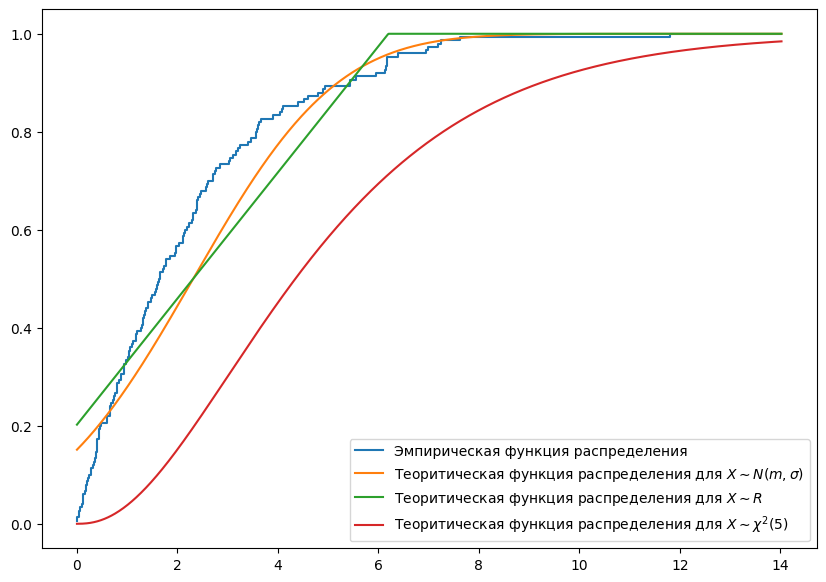

In [16]:
x = np.linspace(sample1.min(), sample1.max(), 1000)
ecdf1 = ECDF(sample1)

plt.figure(figsize=(10, 7))
plt.step(ecdf1.x, ecdf1.y, label='Эмпирическая функция распределения')
plt.plot(x, stats.norm(sample1_m, sample1_s).cdf(x), label='Теоритическая функция распределения для $X \sim N(m, \sigma)$')
plt.plot(x, stats.uniform(a, b - a).cdf(x), label='Теоритическая функция распределения для $X \sim R$')
plt.plot(x, stats.chi2(5).cdf(x), label='Теоритическая функция распределения для $X \sim \chi^2(5)$')

plt.legend()

### 5. Двухвыборочные критерии

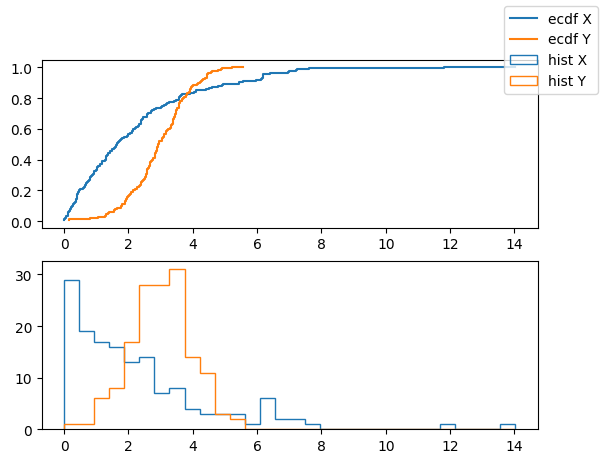

In [32]:
sample2_exp = 3
sample2_sigma = 1

sample2_size = 150
sample2 = stats.norm(sample2_exp, sample2_sigma).rvs(sample2_size)

sample2_m = np.mean(sample2)
sample2_s2 = np.var(sample2, ddof=1)
sample2_s = math.sqrt((sample2_size / (sample2_size - 1)) * sample2_s2)

fig, ax = plt.subplots(2)

ecdf2 = ECDF(sample2)

ax[0].step(ecdf1.x, ecdf1.y, label="ecdf X")
ax[0].step(ecdf2.x, ecdf2.y, label="ecdf Y")

hist, edges, _ = ax[1].hist(sample1, label="hist X", histtype='step', bins=30)
_ = ax[1].hist(sample2, label="hist Y", histtype='step', bins=edges)
fig.legend()

In [25]:
def chisquare_2samp(sample1 : np.ndarray, sample2 : np.ndarray, bins=10):
    hist1, edges = np.histogram(sample1, bins=bins)
    hist2, _ = np.histogram(sample2, bins=edges)

    stat = 0 
    for i in range(hist1.size):
        stat += 1/(hist1[i] + hist2[i])*(hist1[i]/sample1.size - hist2[i]/sample2.size)**2
    
    stat *= sample1.size*sample2.size
    
    pvalue = 1 - stats.chi2(hist1.size - 1).cdf(stat)
    
    return stat, pvalue

stat, pvalue = chisquare_2samp(sample1, sample2, 10)
print(f"chisquare: stat: {stat} pvalue: {pvalue}")

chisquare: stat: 69.326 pvalue: 2.0644042031392473e-11


In [30]:
res = stats.kstest(sample1, sample2)
print(f"kstest: stat: {res.statistic:.3f} pvalue: {res.pvalue}")

from statsmodels.stats.descriptivestats import sign_test 
stat, pvalue = sign_test(sample1 - sample2)
print(f"sign-test: stat: {stat:.3f} pvalue: {pvalue}")

res = stats.ranksums(sample1, sample2)
print(f"u-test: stat: {res.statistic:.3f} pvalue: {res.pvalue}")

kstest: stat: 0.380 pvalue: 4.868724048839319e-10
sign-test: stat: -27.000 pvalue: 1.2305573559865741e-05
u-test: stat: -5.411 pvalue: 6.267755689802169e-08
